In [1]:
import os, sys
import numpy as np
import matplotlib.pyplot as plt
import h5py
import tensorly as tl

Using numpy backend.


In [2]:
%matplotlib inline

## Load previously compiled data

The raw (ping-by-ping) data were averaged to get mean volume backscattering strengh (MVBS) and then cleaned up by PCP. This is the same set of data I used to run the Matlab PALM-NMF.

Note that **all echograms in this notebook are plotted upside-down**, so the DVM you see you opposite of what actually happens. In reality the animals move toward the surface during the night and move downward during the day.

In [3]:
# Load PCP-cleaned MVBS data
MVBS_path = '/home/wu-jung/code_git/ooi_sonar/sample_data/'
MVBS_fname = '20150817-20151017_MVBS_PCPcleaned.h5'

import h5py
f = h5py.File(os.path.join(MVBS_path,MVBS_fname),'r')

In [4]:
# Load low-rank data
L = np.array(f['L'])
L_sep = np.array(f['L_sep'])
L_plot = np.array(f['L_plot'])
depth_bin_size = np.array(f['depth_bin_size'])
ping_per_day_mvbs = np.array(f['ping_per_day_mvbs'])
ping_time = np.array(f['ping_time'])
f.close()

The data is organized with dimension [frequency x number of days x depth x time of day].

In [5]:
L_sep.shape

(3, 62, 37, 144)

The 3 frequencies of data look like:

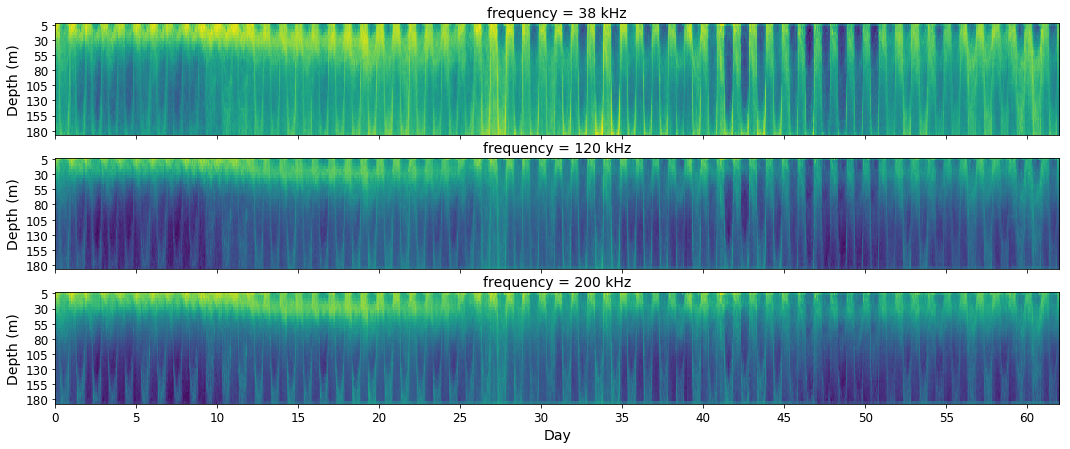

In [6]:
freq = [38,120,200]

fig,ax = plt.subplots(3,1,figsize=(18,7),sharex=True)
for f in range(3):
    ax[f].imshow(tl.unfold(tl.tensor(L_sep[f,:,:,:].squeeze()),mode=1)[::-1,:],aspect='auto')
    ax[f].set_xticks(range(0,65*144,144*5))
    ax[f].set_xticklabels(range(0,65,5))
    ax[f].set_yticks(range(0,37,5))
    ax[f].set_yticklabels((np.arange(0,37,5)+1)*depth_bin_size)
    plt.setp(ax[f].get_xticklabels(), fontsize=12)
    plt.setp(ax[f].get_yticklabels(), fontsize=12)
    if ax[f].is_last_row():
        plt.xlabel('Day',fontsize=14)
    ax[f].set_ylabel('Depth (m)',fontsize=14)
    ax[f].set_title('frequency = %d kHz' % freq[f], fontsize=14)

## Decimating data

In [7]:
# Average across time of day columns
tod_num = 6
L_sep_reduce = np.empty(np.hstack((np.array(L_sep.shape[:3]),int(L_sep.shape[-1]/tod_num))))
for i in np.arange(int(L_sep.shape[-1]/tod_num)):
    L_sep_reduce[:,:,:,i] = np.mean(L_sep[:,:,:,i*tod_num+np.arange(tod_num)],axis=3)

In [8]:
L_sep_reduce.shape

(3, 62, 37, 24)

On the grand scale the decimated data look very similar to without averaging over the pings:

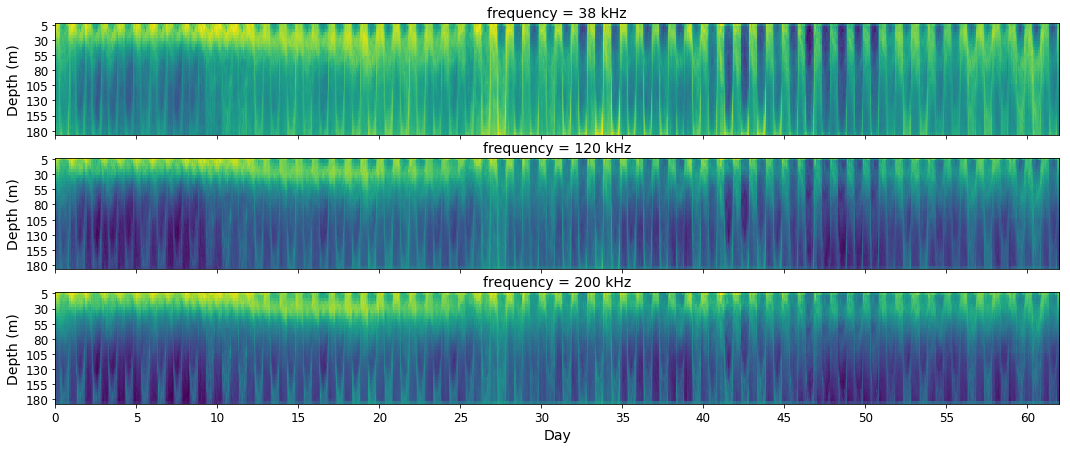

In [9]:
freq = [38,120,200]

fig,ax = plt.subplots(3,1,figsize=(18,7),sharex=True)
for f in range(3):
    ax[f].imshow(tl.unfold(tl.tensor(L_sep_reduce[f,:,:,:].squeeze()),mode=1)[::-1,:],aspect='auto')
    ax[f].set_xticks(range(0,int(65*144/tod_num),int(144/tod_num*5)))
    ax[f].set_xticklabels(range(0,65,5))
    ax[f].set_yticks(range(0,37,5))
    ax[f].set_yticklabels((np.arange(0,37,5)+1)*depth_bin_size)
    plt.setp(ax[f].get_xticklabels(), fontsize=12)
    plt.setp(ax[f].get_yticklabels(), fontsize=12)
    if ax[f].is_last_row():
        plt.xlabel('Day',fontsize=14)
    ax[f].set_ylabel('Depth (m)',fontsize=14)
    ax[f].set_title('frequency = %d kHz' % freq[f], fontsize=14)

But obviously the effects are more prominent when you look at only a smaller number of days:

First we look at the original MVBS data for the first 10 days:

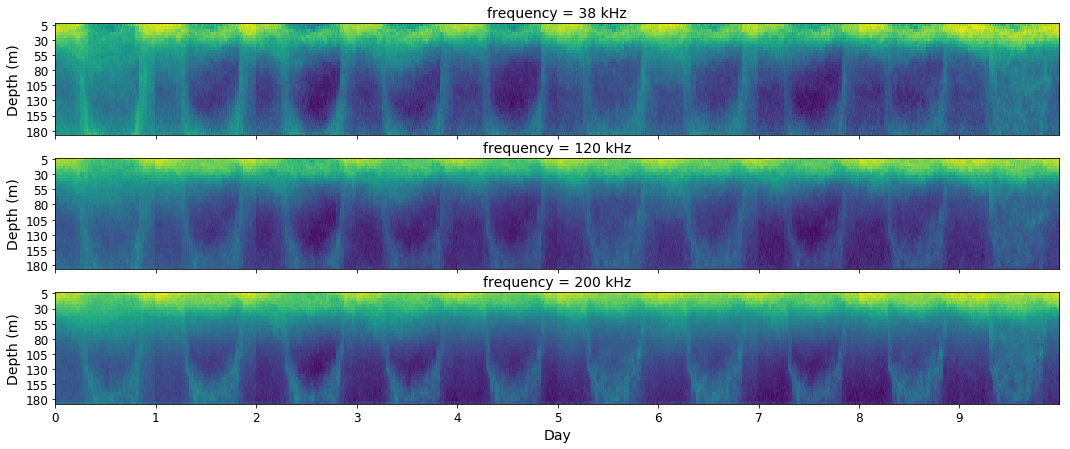

In [10]:
freq = [38,120,200]

fig,ax = plt.subplots(3,1,figsize=(18,7),sharex=True)
for f in range(3):
    ax[f].imshow(tl.unfold(tl.tensor(L_sep[f,:10,:,:].squeeze()),mode=1)[::-1,:],aspect='auto')
    ax[f].set_xticks(range(0,10*144,144))
    ax[f].set_xticklabels(range(0,11,1))
    ax[f].set_yticks(range(0,37,5))
    ax[f].set_yticklabels((np.arange(0,37,5)+1)*depth_bin_size)
    plt.setp(ax[f].get_xticklabels(), fontsize=12)
    plt.setp(ax[f].get_yticklabels(), fontsize=12)
    if ax[f].is_last_row():
        plt.xlabel('Day',fontsize=14)
    ax[f].set_ylabel('Depth (m)',fontsize=14)
    ax[f].set_title('frequency = %d kHz' % freq[f], fontsize=14)

And then we compare it with the decimated data:

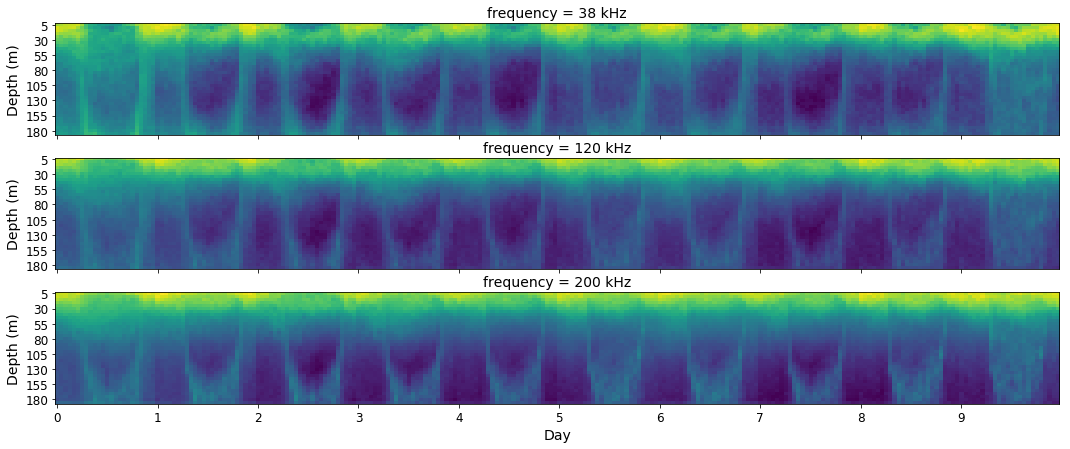

In [11]:
freq = [38,120,200]

fig,ax = plt.subplots(3,1,figsize=(18,7),sharex=True)
for f in range(3):
    ax[f].imshow(tl.unfold(tl.tensor(L_sep_reduce[f,:10,:,:].squeeze()),mode=1)[::-1,:],aspect='auto')
    ax[f].set_xticks(range(0,int(10*144/tod_num),int(144/tod_num*1)))
    ax[f].set_xticklabels(range(0,11,1))
    ax[f].set_yticks(range(0,37,5))
    ax[f].set_yticklabels((np.arange(0,37,5)+1)*depth_bin_size)
    plt.setp(ax[f].get_xticklabels(), fontsize=12)
    plt.setp(ax[f].get_yticklabels(), fontsize=12)
    if ax[f].is_last_row():
        plt.xlabel('Day',fontsize=14)
    ax[f].set_ylabel('Depth (m)',fontsize=14)
    ax[f].set_title('frequency = %d kHz' % freq[f], fontsize=14)

## Reshaping to form tensor with daily ping-by-ping observations stacked together

In [12]:
L_sep_reduce.shape

(3, 62, 37, 24)

In [13]:
L_sep_reduce_reshape = L_sep_reduce.reshape((3,62,37*24))

Plotting out to check how the unfolded reshaped matrix looks like:

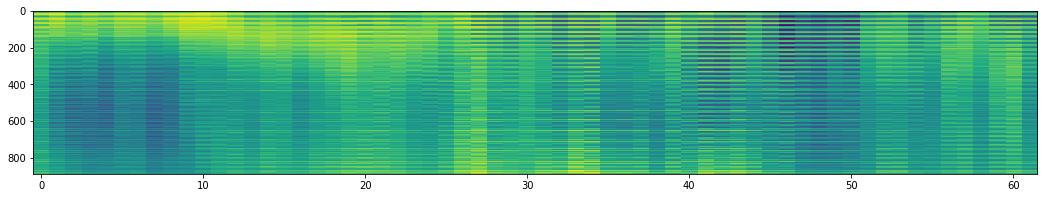

In [14]:
fig = plt.figure(figsize=(18,3))
plt.imshow(tl.unfold(tl.tensor(L_sep_reduce_reshape[0,:,:]),mode=1)[::-1,:],aspect='auto')
plt.show()

In [15]:
37*24

888

In [16]:
A = tl.unfold(tl.tensor(L_sep_reduce_reshape[0,:,:]),mode=1)
A.shape

(888, 62)

Making sure I am getting the reshaping right by trying to reconstruct the first day at 3 frequencies:

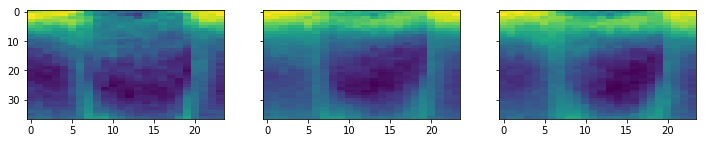

In [17]:
fig,ax = plt.subplots(1,3,figsize=(12,2),sharey=True)
for f in range(3):
    ax[f].imshow(A[:,f].reshape((37,24))[::-1,:],aspect='auto')
plt.show()

I am doing the reshaping to combine the depth and hour dimension, because for parafac, it is not possible for a single component to capture the DVM, since that type of pattern is not possible for an outer product of two vectors. Under this constraint I think it makes more sense to go back to treating the echograms as images as done when using NMF, but here we could throw in data from different frequencies along one dimension instead of concatenating them together.

With the above confirmation now we define the sonar tensor:

In [18]:
sonar_tensor = tl.tensor(L_sep_reduce_reshape)

In [19]:
sonar_tensor.shape

(3, 62, 888)

# Try parafac decomposition

Before in 2018-10-29 notebook was trying to do parafac decomposition of data from 1 frequency. Now try to see if can run 4D decomposition with frequency being one of the dimensions.

In [20]:
# kruskal decomposition is parafac in tensorly
from tensorly.decomposition import parafac, non_negative_parafac
from tensorly.tenalg import kronecker, khatri_rao

### Rank=3

In [21]:
kruskal_rank = 3
factors_kruskal_3 = parafac(sonar_tensor, rank = kruskal_rank)
factors_kruskal_nonneg_3 = non_negative_parafac(sonar_tensor-sonar_tensor.min(), rank = kruskal_rank)

In [22]:
[factors_kruskal_3[f].shape for f in range(len(factors_kruskal_3))]

[(3, 3), (62, 3), (888, 3)]

In [23]:
full_tensor_3 = tl.kruskal_to_tensor(factors_kruskal_3)
full_tensor_nonneg_3 = tl.kruskal_to_tensor(factors_kruskal_nonneg_3)

In [24]:
full_tensor_3.shape

(3, 62, 888)

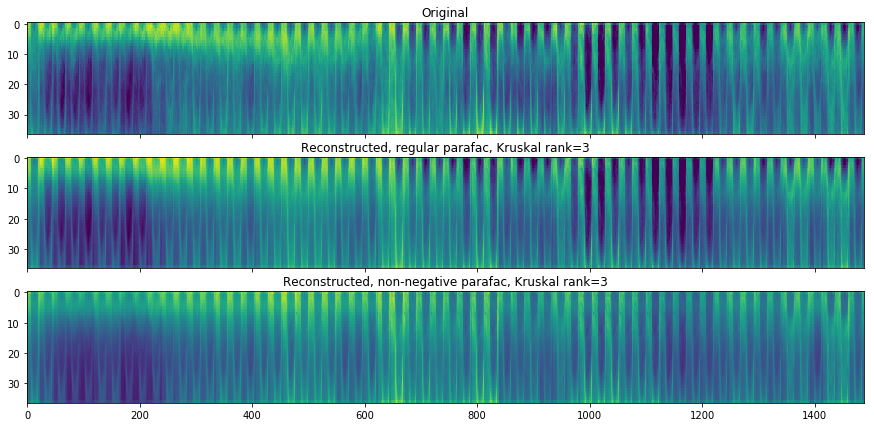

In [25]:
fig,ax = plt.subplots(3,1,figsize=(15,7),sharex=True)
ax[0].imshow(tl.unfold(tl.tensor(sonar_tensor[0,:,:].reshape((62,37,24))).squeeze(), mode=1)[::-1,:],
             aspect='auto',vmax=-57, vmin=-85)
ax[0].set_title('Original')
ax[1].imshow(tl.unfold(tl.tensor(full_tensor_3[0,:,:].reshape((62,37,24))).squeeze(), mode=1)[::-1,:],
             aspect='auto',vmax=-57, vmin=-85)
ax[1].set_title('Reconstructed, regular parafac, Kruskal rank=%d'%kruskal_rank)
ax[2].imshow(tl.unfold(tl.tensor(full_tensor_nonneg_3[0,:,:].reshape((62,37,24))+sonar_tensor.min()).squeeze(), mode=1)[::-1,:],
             aspect='auto',vmax=-57, vmin=-85)
ax[2].set_title('Reconstructed, non-negative parafac, Kruskal rank=%d'%kruskal_rank)
plt.show()

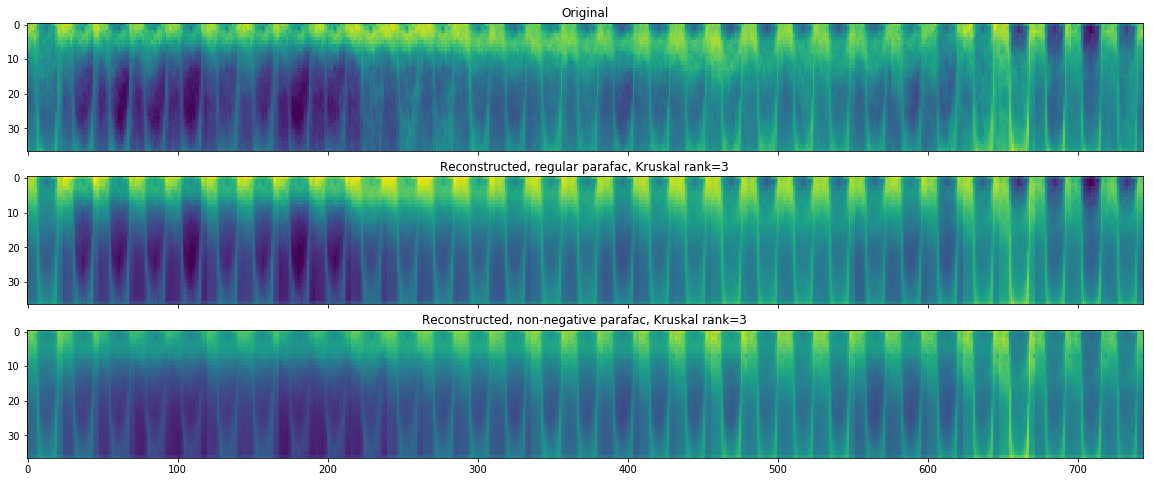

In [26]:
fig,ax = plt.subplots(3,1,figsize=(20,8),sharex=True)
ax[0].imshow(tl.unfold(tl.tensor(sonar_tensor[0:,:31,:].reshape((-1,37,24))).squeeze(), mode=1)[::-1,:],
             aspect='auto',vmax=-57, vmin=-85)
ax[0].set_title('Original')
ax[1].imshow(tl.unfold(tl.tensor(full_tensor_3[0,:31,:].reshape((-1,37,24))).squeeze(), mode=1)[::-1,:],
             aspect='auto',vmax=-57, vmin=-85)
ax[1].set_title('Reconstructed, regular parafac, Kruskal rank=%d'%kruskal_rank)
ax[2].imshow(tl.unfold(tl.tensor(full_tensor_nonneg_3[0,:31,:].reshape((-1,37,24))+sonar_tensor.min()).squeeze(), mode=1)[::-1,:],
             aspect='auto',vmax=-57, vmin=-85)
ax[2].set_title('Reconstructed, non-negative parafac, Kruskal rank=%d'%kruskal_rank)
plt.show()

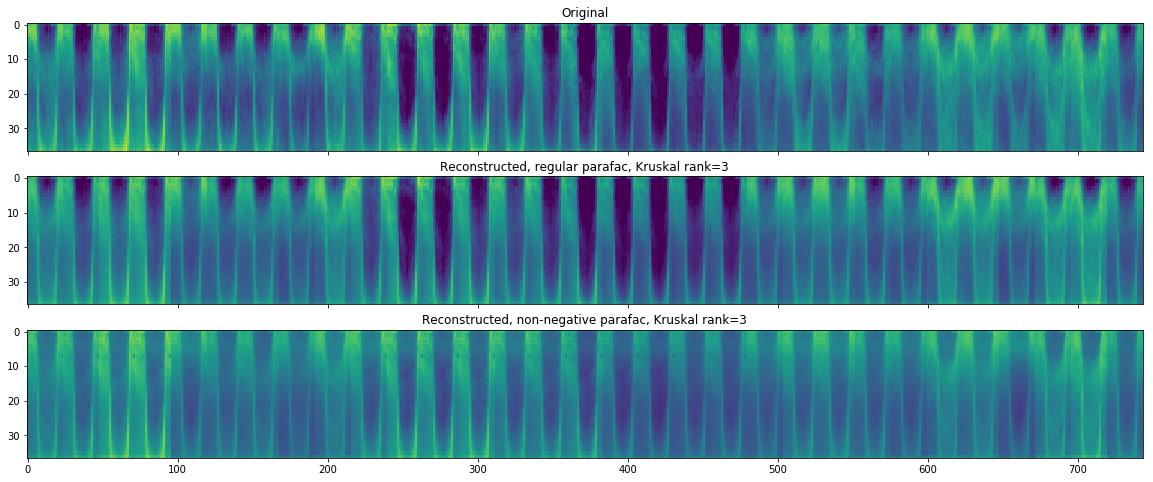

In [27]:
fig,ax = plt.subplots(3,1,figsize=(20,8),sharex=True)
ax[0].imshow(tl.unfold(tl.tensor(sonar_tensor[0:,31:,:].reshape((-1,37,24))).squeeze(), mode=1)[::-1,:],
             aspect='auto',vmax=-57, vmin=-85)
ax[0].set_title('Original')
ax[1].imshow(tl.unfold(tl.tensor(full_tensor_3[0,31:,:].reshape((-1,37,24))).squeeze(), mode=1)[::-1,:],
             aspect='auto',vmax=-57, vmin=-85)
ax[1].set_title('Reconstructed, regular parafac, Kruskal rank=%d'%kruskal_rank)
ax[2].imshow(tl.unfold(tl.tensor(full_tensor_nonneg_3[0,31:,:].reshape((-1,37,24))+sonar_tensor.min()).squeeze(), mode=1)[::-1,:],
             aspect='auto',vmax=-57, vmin=-85)
ax[2].set_title('Reconstructed, non-negative parafac, Kruskal rank=%d'%kruskal_rank)
plt.show()

## Checking regular parafac results

In [28]:
sonar_tensor.shape

(3, 62, 888)

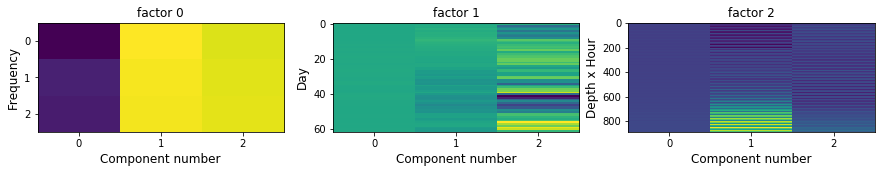

In [29]:
fig,ax = plt.subplots(1,3,figsize=(15,2))
for i in range(3):
    ax[i].imshow(factors_kruskal_3[i],aspect='auto')
    ax[i].set_title('factor %d' % i)
    ax[i].set_xlabel('Component number',fontsize=12)
    if i==0:
        ax[i].set_ylabel('Frequency',fontsize=12)
    elif i==1:
        ax[i].set_ylabel('Day',fontsize=12)
    else:
        ax[i].set_ylabel('Depth x Hour',fontsize=12)
    ax[i].set_xticks(np.arange(kruskal_rank))

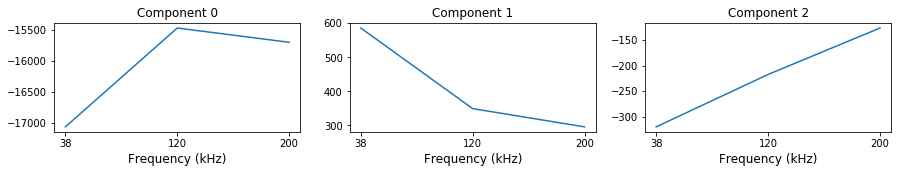

In [30]:
fig,ax = plt.subplots(1,3,figsize=(15,2))
for i in range(3):
    ax[i].plot(factors_kruskal_3[0][:,i],label=i)
    ax[i].set_title('Component %d'% i)
    ax[i].set_xticks(np.arange(3))
    ax[i].set_xticklabels([38,120,200])
    ax[i].set_xlabel('Frequency (kHz)', fontsize=12)
plt.show()

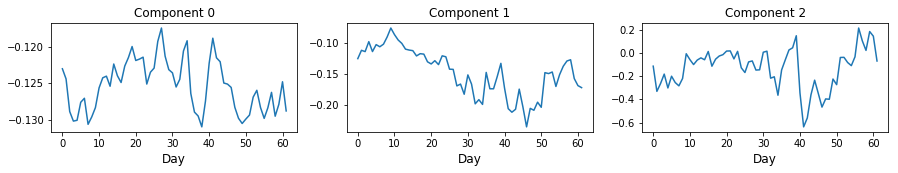

In [31]:
fig,ax = plt.subplots(1,3,figsize=(15,2))
for i in range(3):
    ax[i].plot(factors_kruskal_3[1][:,i],label=i)
    ax[i].set_xticks(np.arange(0,62,10))
    ax[i].set_xticklabels(np.arange(0,62,10))
    ax[i].set_title('Component %d'% i)
    ax[i].set_xlabel('Day',fontsize=12)
plt.show()

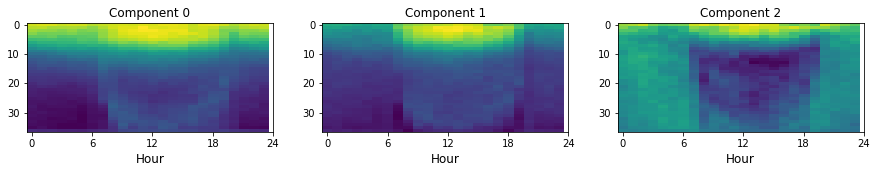

In [32]:
fig,ax = plt.subplots(1,3,figsize=(15,2))
for i in range(3):
    ax[i].imshow(factors_kruskal_3[2][:,i].reshape((37,24))[::-1,:],aspect='auto')
    ax[i].set_title('Component %d'% i)
    ax[i].set_xticks(np.arange(0,25,6))
    ax[i].set_xticklabels(np.arange(0,25,6))
    ax[i].set_xlabel('Hour', fontsize=12)
plt.show()

## Combine pairs of factors (regular parafac)

In [33]:
import itertools

In [34]:
# Khatri-kao product to combine the factors
kr_patterns = []
kr_combs = []
for x,y in itertools.combinations(range(3),2):
    kr_patterns.append((x,y))
    kr_combs.append(khatri_rao((factors_kruskal_3[x],factors_kruskal_3[y])))

In [35]:
sonar_tensor.shape

(3, 62, 888)

In [36]:
kr_patterns

[(0, 1), (0, 2), (1, 2)]

In [37]:
[x.shape for x in kr_combs]

[(186, 3), (2664, 3), (55056, 3)]

### Interaction between frequency and day

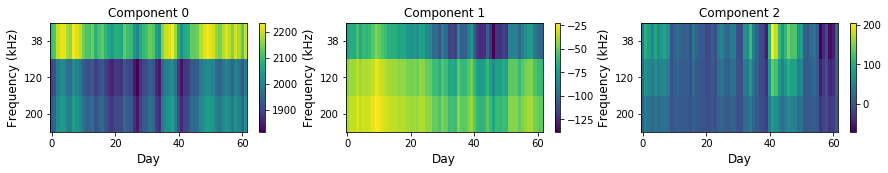

In [38]:
fac_num = 3
fig = plt.figure(figsize=(15,2))
for fac in range(fac_num):
    fig.add_subplot(1,fac_num,fac+1)
    plt.title('Component %d'% fac)    
    plt.imshow(kr_combs[0][:,fac].reshape(3,62),aspect='auto')
    plt.xticks(np.arange(0,62,20))
    plt.xlabel('Day', fontsize=12)
    plt.yticks(np.arange(3),[38,120,200])
    plt.ylabel('Frequency (kHz)', fontsize=12)
    plt.colorbar()

### Interaction between frequency and daily image

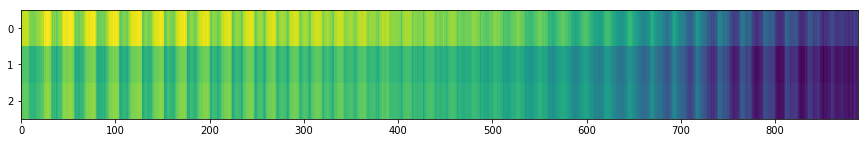

In [39]:
fig = plt.figure(figsize=(15,2))
plt.imshow(kr_combs[1][:,0].reshape(3,888),aspect='auto')
plt.show()

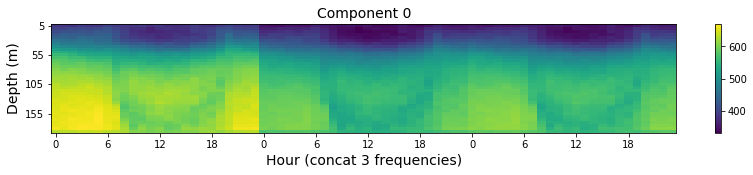

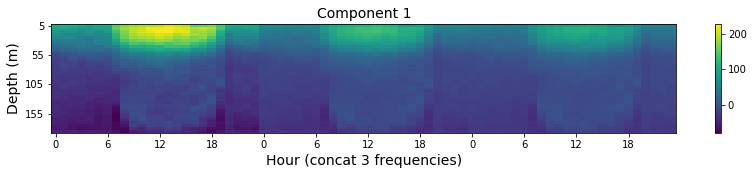

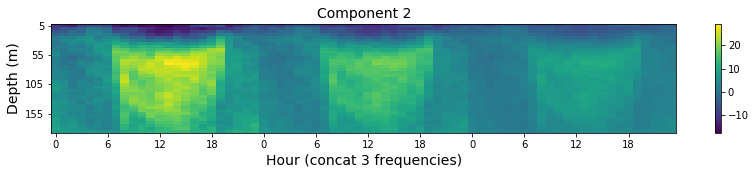

In [40]:
fac_num = 3
for fac in range(fac_num):
    fig = plt.figure(figsize=(14,2))
    plt.imshow(tl.unfold(tl.tensor(kr_combs[1][:,fac].reshape(3,37,24)[:,::-1,:]),mode=1),aspect='auto')
    plt.xticks(np.arange(0,24*3,6),np.hstack([np.arange(0,24,6),]*3))
    plt.xlabel('Hour (concat 3 frequencies)', fontsize=14)
    plt.yticks(np.arange(0,37,10),(np.arange(0,37,10)+1)*depth_bin_size)
    plt.ylabel('Depth (m)', fontsize=14)
    plt.title('Component %d' % fac, fontsize=14)
    plt.colorbar() 
    plt.show()

### Interaction between day and daily image

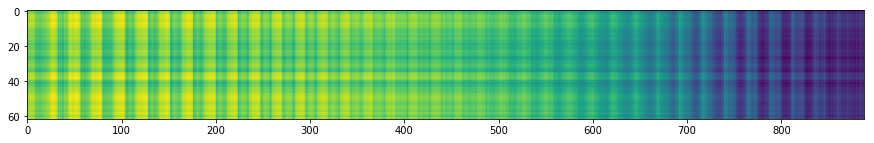

In [41]:
fig = plt.figure(figsize=(15,2))
plt.imshow(kr_combs[2][:,0].reshape(62,888),aspect='auto')
plt.show()

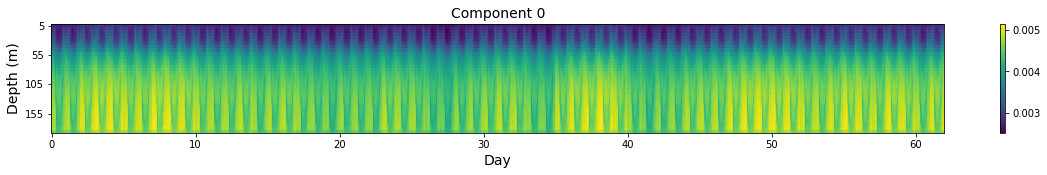

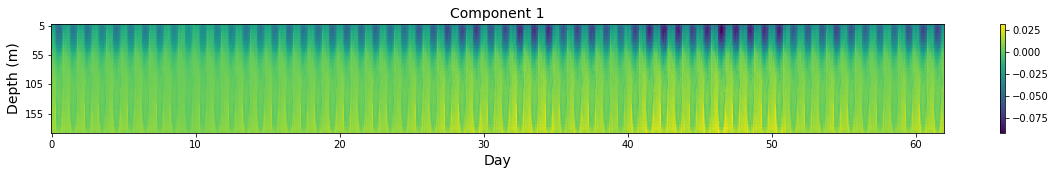

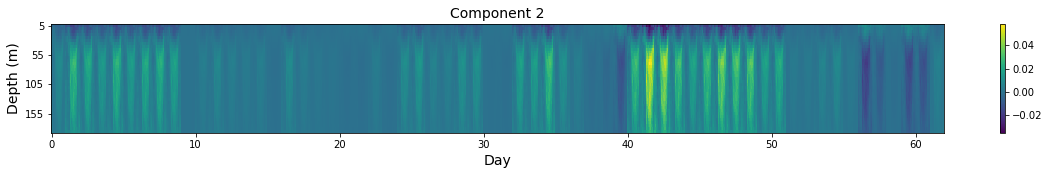

In [42]:
fac_num = 3
for fac in range(fac_num):
    fig = plt.figure(figsize=(20,2))
    plt.imshow(tl.unfold(tl.tensor(kr_combs[2][:,fac].reshape(62,37,24)[:,::-1,:]),mode=1),aspect='auto')
    plt.xticks(np.arange(0,24*62,24*10),np.arange(0,62,10))
    plt.xlabel('Day', fontsize=14)
    plt.yticks(np.arange(0,37,10),(np.arange(0,37,10)+1)*depth_bin_size)
    plt.ylabel('Depth (m)', fontsize=14)
    plt.title('Component %d' % fac, fontsize=14)
    plt.colorbar()
    plt.show()

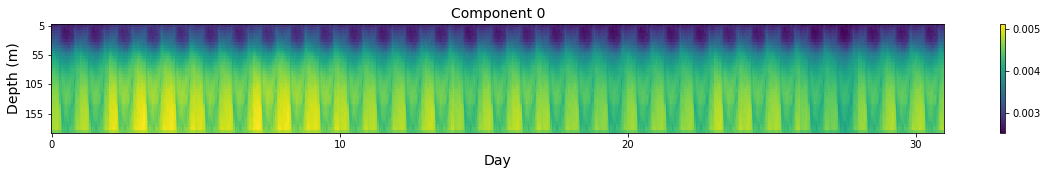

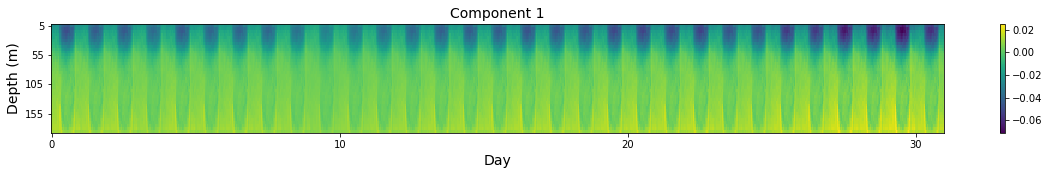

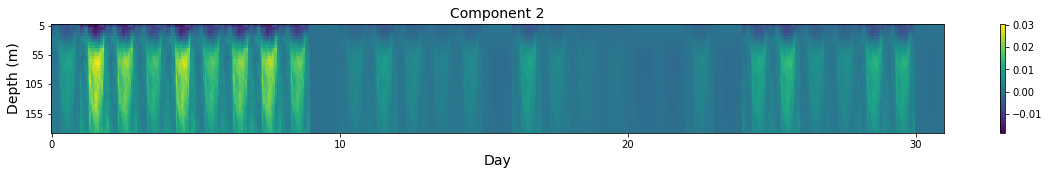

In [43]:
fac_num = 3
for fac in range(fac_num):
    fig = plt.figure(figsize=(20,2))
    plt.imshow(tl.unfold(tl.tensor(kr_combs[2][:,fac].reshape(62,37,24)[:31,::-1,:]),mode=1),aspect='auto')
    plt.xticks(np.arange(0,24*31,24*10),np.arange(0,31,10))
    plt.xlabel('Day', fontsize=14)
    plt.yticks(np.arange(0,37,10),(np.arange(0,37,10)+1)*depth_bin_size)
    plt.ylabel('Depth (m)', fontsize=14)
    plt.title('Component %d' % fac, fontsize=14)
    plt.colorbar()
    plt.show()

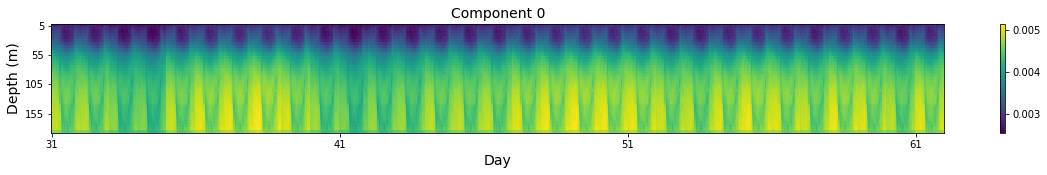

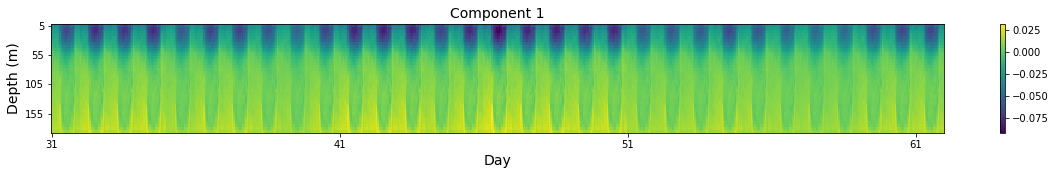

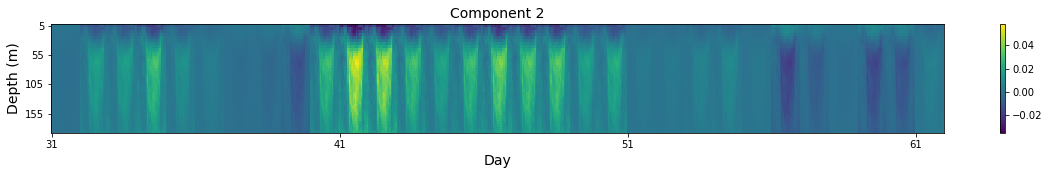

In [44]:
fac_num = 3
for fac in range(fac_num):
    fig = plt.figure(figsize=(20,2))
    plt.imshow(tl.unfold(tl.tensor(kr_combs[2][:,fac].reshape(62,37,24)[31:,::-1,:]),mode=1),aspect='auto')
    plt.xticks(np.arange(0,24*31,24*10),np.arange(0,31,10)+31)
    plt.xlabel('Day', fontsize=14)
    plt.yticks(np.arange(0,37,10),(np.arange(0,37,10)+1)*depth_bin_size)
    plt.ylabel('Depth (m)', fontsize=14)
    plt.title('Component %d' % fac, fontsize=14)
    plt.colorbar()
    plt.show()

## Checking non-negative parafac results

In [45]:
sonar_tensor.shape

(3, 62, 888)

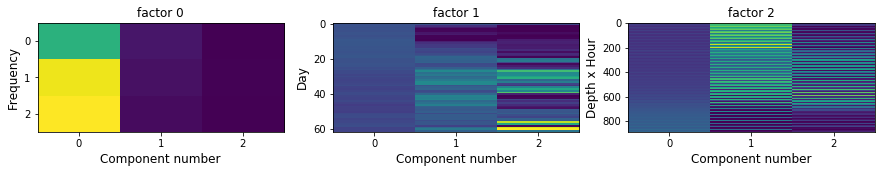

In [46]:
fig,ax = plt.subplots(1,3,figsize=(15,2))
for i in range(3):
    ax[i].imshow(factors_kruskal_nonneg_3[i],aspect='auto')
    ax[i].set_title('factor %d' % i)
    ax[i].set_xlabel('Component number',fontsize=12)
    if i==0:
        ax[i].set_ylabel('Frequency',fontsize=12)
    elif i==1:
        ax[i].set_ylabel('Day',fontsize=12)
    else:
        ax[i].set_ylabel('Depth x Hour',fontsize=12)
    ax[i].set_xticks(np.arange(kruskal_rank))

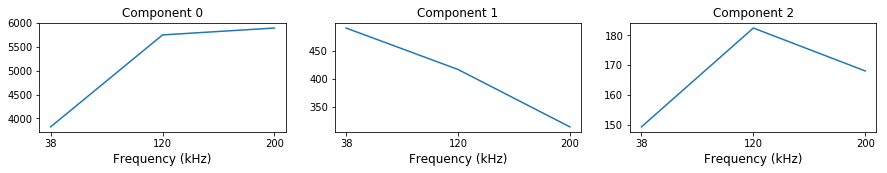

In [47]:
fig,ax = plt.subplots(1,3,figsize=(15,2))
for i in range(3):
    ax[i].plot(factors_kruskal_nonneg_3[0][:,i],label=i)
    ax[i].set_title('Component %d'% i)
    ax[i].set_xticks(np.arange(3))
    ax[i].set_xticklabels([38,120,200])
    ax[i].set_xlabel('Frequency (kHz)', fontsize=12)
plt.show()

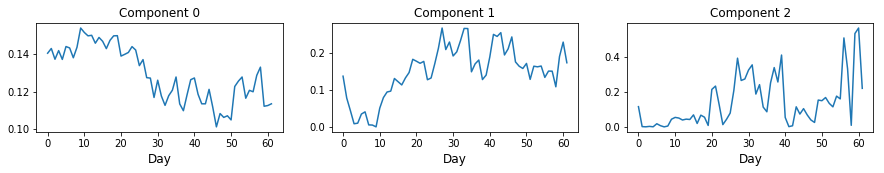

In [48]:
fig,ax = plt.subplots(1,3,figsize=(15,2))
for i in range(3):
    ax[i].plot(factors_kruskal_nonneg_3[1][:,i],label=i)
    ax[i].set_xticks(np.arange(0,62,10))
    ax[i].set_xticklabels(np.arange(0,62,10))
    ax[i].set_title('Component %d'% i)
    ax[i].set_xlabel('Day',fontsize=12)
plt.show()

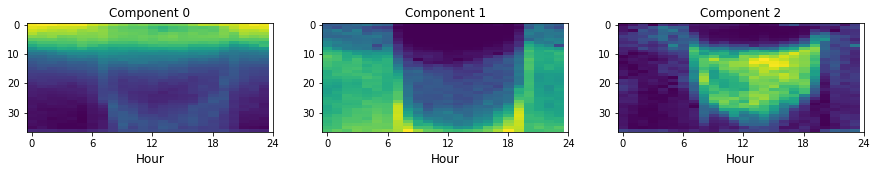

In [49]:
fig,ax = plt.subplots(1,3,figsize=(15,2))
for i in range(3):
    ax[i].imshow(factors_kruskal_nonneg_3[2][:,i].reshape((37,24))[::-1,:],aspect='auto')
    ax[i].set_title('Component %d'% i)
    ax[i].set_xticks(np.arange(0,25,6))
    ax[i].set_xticklabels(np.arange(0,25,6))
    ax[i].set_xlabel('Hour', fontsize=12)
plt.show()

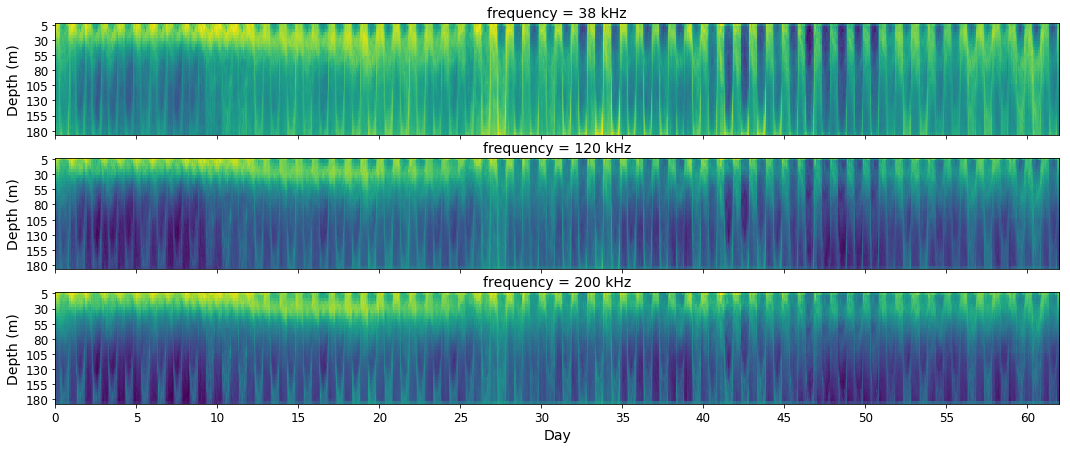

In [50]:
freq = [38,120,200]

fig,ax = plt.subplots(3,1,figsize=(18,7),sharex=True)
for f in range(3):
    ax[f].imshow(tl.unfold(tl.tensor(L_sep_reduce[f,:,:,:].squeeze()),mode=1)[::-1,:],aspect='auto')
    ax[f].set_xticks(range(0,int(65*144/tod_num),int(144/tod_num*5)))
    ax[f].set_xticklabels(range(0,65,5))
    ax[f].set_yticks(range(0,37,5))
    ax[f].set_yticklabels((np.arange(0,37,5)+1)*depth_bin_size)
    plt.setp(ax[f].get_xticklabels(), fontsize=12)
    plt.setp(ax[f].get_yticklabels(), fontsize=12)
    if ax[f].is_last_row():
        plt.xlabel('Day',fontsize=14)
    ax[f].set_ylabel('Depth (m)',fontsize=14)
    ax[f].set_title('frequency = %d kHz' % freq[f], fontsize=14)

## Combine pairs of factors (non-negative parafac)

In [51]:
import itertools

In [52]:
# Khatri-kao product to combine the factors
kr_nn_patterns = []
kr_nn_combs = []
for x,y in itertools.combinations(range(3),2):
    kr_nn_patterns.append((x,y))
    kr_nn_combs.append(khatri_rao((factors_kruskal_nonneg_3[x],factors_kruskal_nonneg_3[y])))

In [53]:
sonar_tensor.shape

(3, 62, 888)

In [54]:
kr_nn_patterns

[(0, 1), (0, 2), (1, 2)]

In [55]:
[x.shape for x in kr_nn_combs]

[(186, 3), (2664, 3), (55056, 3)]

### Interaction between frequency and day

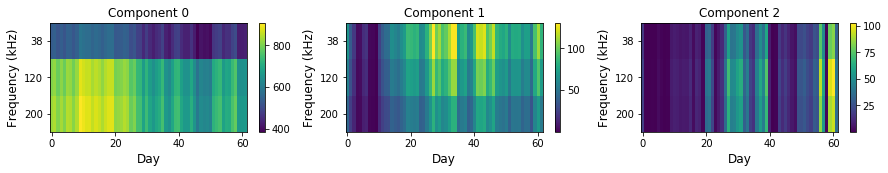

In [56]:
fac_num = 3
fig = plt.figure(figsize=(15,2))
for fac in range(fac_num):
    fig.add_subplot(1,fac_num,fac+1)
    plt.title('Component %d'% fac)    
    plt.imshow(kr_nn_combs[0][:,fac].reshape(3,62),aspect='auto')
    plt.xticks(np.arange(0,62,20))
    plt.xlabel('Day', fontsize=12)
    plt.yticks(np.arange(3),[38,120,200])
    plt.ylabel('Frequency (kHz)', fontsize=12)
    plt.colorbar()

### Interaction between frequency and daily image

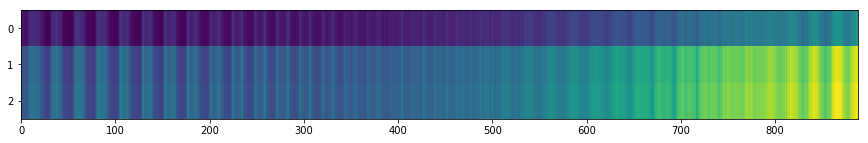

In [57]:
fig = plt.figure(figsize=(15,2))
plt.imshow(kr_nn_combs[1][:,0].reshape(3,888),aspect='auto')
plt.show()

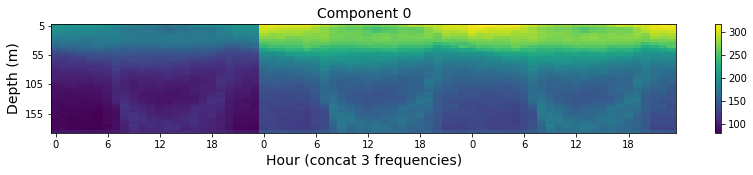

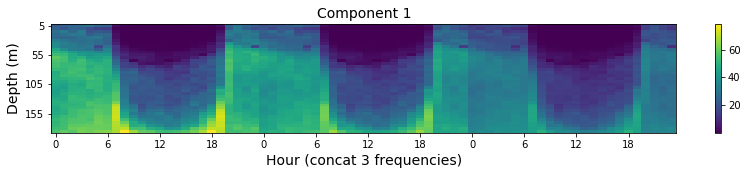

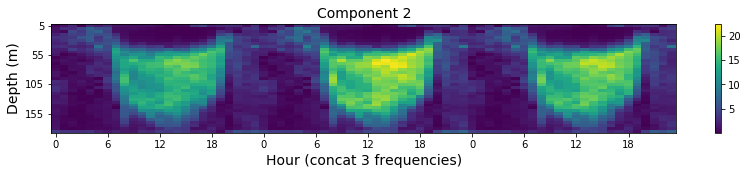

In [58]:
fac_num = 3
for fac in range(fac_num):
    fig = plt.figure(figsize=(14,2))
    plt.imshow(tl.unfold(tl.tensor(kr_nn_combs[1][:,fac].reshape(3,37,24)[:,::-1,:]),mode=1),aspect='auto')
    plt.xticks(np.arange(0,24*3,6),np.hstack([np.arange(0,24,6),]*3))
    plt.xlabel('Hour (concat 3 frequencies)', fontsize=14)
    plt.yticks(np.arange(0,37,10),(np.arange(0,37,10)+1)*depth_bin_size)
    plt.ylabel('Depth (m)', fontsize=14)
    plt.title('Component %d' % fac, fontsize=14)
    plt.colorbar() 
    plt.show()

### Interaction between day and daily image

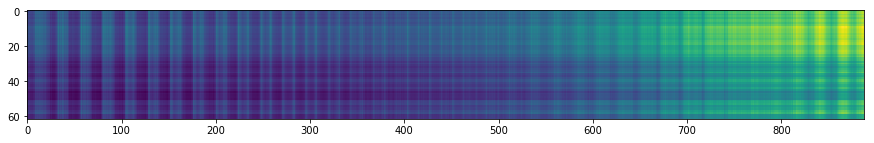

In [59]:
fig = plt.figure(figsize=(15,2))
plt.imshow(kr_nn_combs[2][:,0].reshape(62,888),aspect='auto')
plt.show()

We can reshape each column of the above to became a daily image (888 = 37*24), plotted below.

But the plots don't quite make sense because the summation is over all 3 frequencies and in the actual data this combination doesn't happen. Nevertheless it's interesting to look at what each pattern represetns.

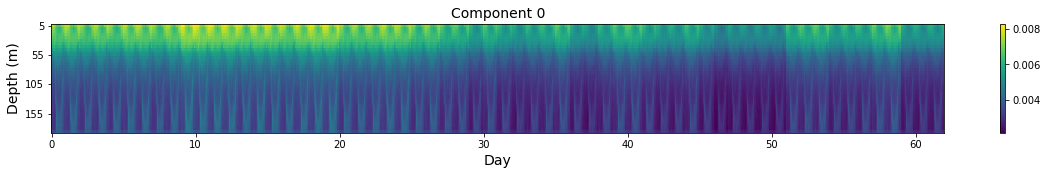

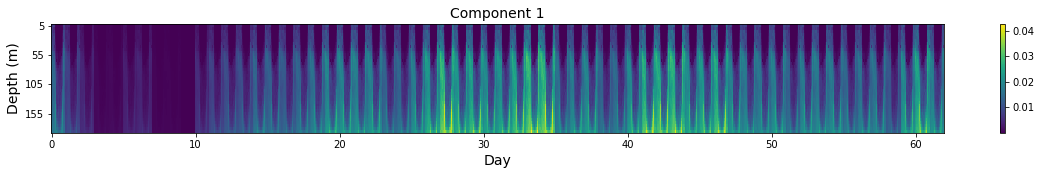

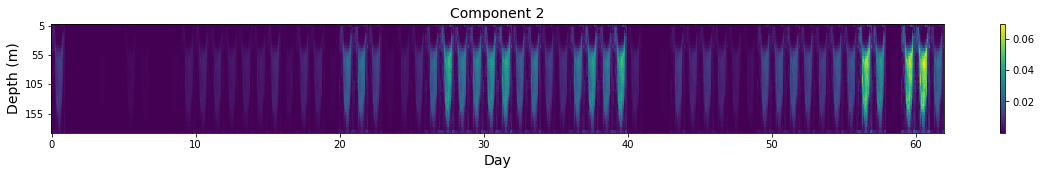

In [60]:
fac_num = 3
for fac in range(fac_num):
    fig = plt.figure(figsize=(20,2))
    plt.imshow(tl.unfold(tl.tensor(kr_nn_combs[2][:,fac].reshape(62,37,24)[:,::-1,:]),mode=1),aspect='auto')
    plt.xticks(np.arange(0,24*62,24*10),np.arange(0,62,10))
    plt.xlabel('Day', fontsize=14)
    plt.yticks(np.arange(0,37,10),(np.arange(0,37,10)+1)*depth_bin_size)
    plt.ylabel('Depth (m)', fontsize=14)
    plt.title('Component %d' % fac, fontsize=14)
    plt.colorbar()
    plt.show()

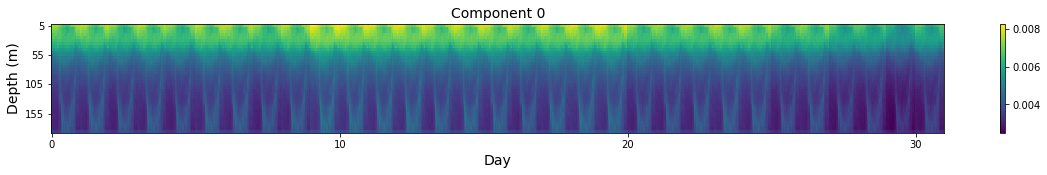

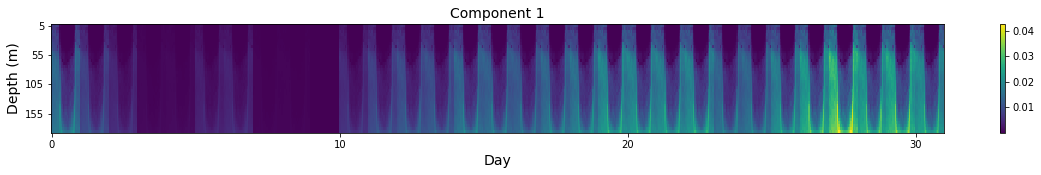

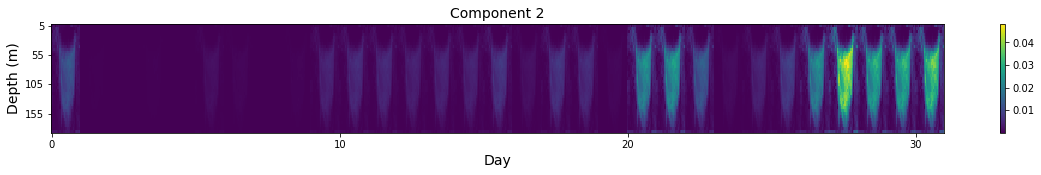

In [61]:
fac_num = 3
for fac in range(fac_num):
    fig = plt.figure(figsize=(20,2))
    plt.imshow(tl.unfold(tl.tensor(kr_nn_combs[2][:,fac].reshape(62,37,24)[:31,::-1,:]),mode=1),aspect='auto')
    plt.xticks(np.arange(0,24*31,24*10),np.arange(0,31,10))
    plt.xlabel('Day', fontsize=14)
    plt.yticks(np.arange(0,37,10),(np.arange(0,37,10)+1)*depth_bin_size)
    plt.ylabel('Depth (m)', fontsize=14)
    plt.title('Component %d' % fac, fontsize=14)
    plt.colorbar()
    plt.show()

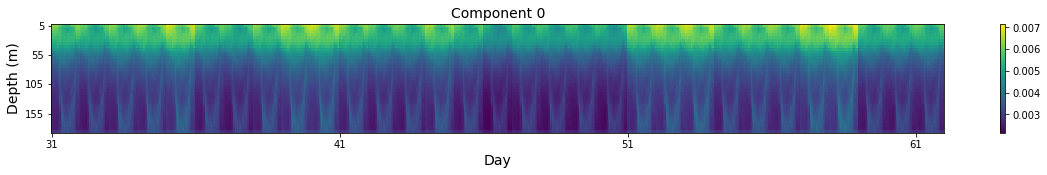

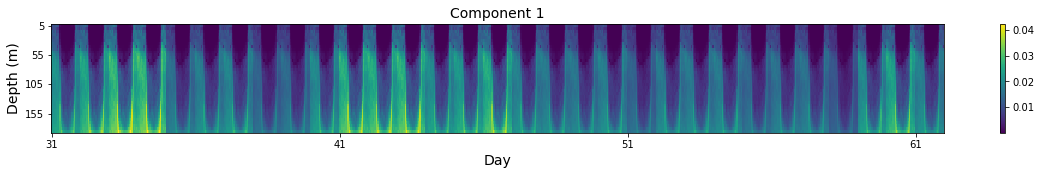

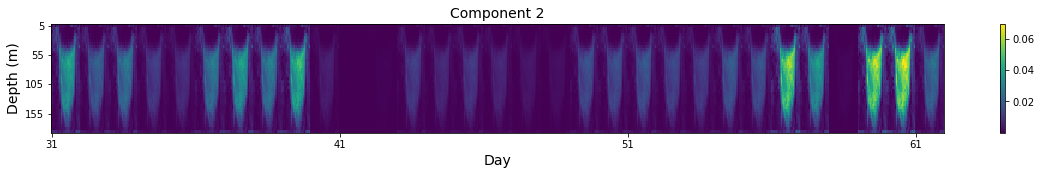

In [62]:
fac_num = 3
for fac in range(fac_num):
    fig = plt.figure(figsize=(20,2))
    plt.imshow(tl.unfold(tl.tensor(kr_nn_combs[2][:,fac].reshape(62,37,24)[31:,::-1,:]),mode=1),aspect='auto')
    plt.xticks(np.arange(0,24*31,24*10),np.arange(0,31,10)+31)
    plt.xlabel('Day', fontsize=14)
    plt.yticks(np.arange(0,37,10),(np.arange(0,37,10)+1)*depth_bin_size)
    plt.ylabel('Depth (m)', fontsize=14)
    plt.title('Component %d' % fac, fontsize=14)
    plt.colorbar()
    plt.show()

## Try manual reconstruction to make sure I know what's going on

In [63]:
L_sep_reduce.shape

(3, 62, 37, 24)

In [64]:
kr_nn_cube_all = khatri_rao((factors_kruskal_nonneg_3[0],
                             factors_kruskal_nonneg_3[1],
                             factors_kruskal_nonneg_3[2]))
kr_nn_cube_all.shape

(165168, 3)

In [65]:
3*62*37*24

165168

In [66]:
kr_nn_cube_all_fac = [kr_nn_cube_all[:,comp].reshape(L_sep_reduce.shape) for comp in range(3)]

In [67]:
kr_nn_cube_all_fac[0].shape

(3, 62, 37, 24)

### Frequency = 38 kHz

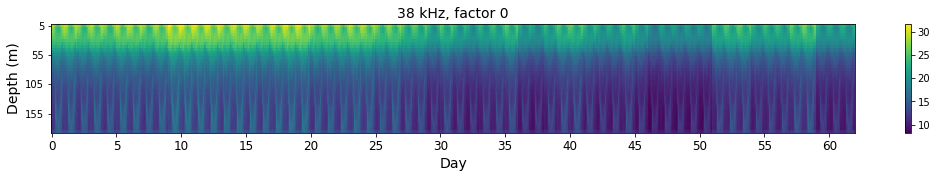

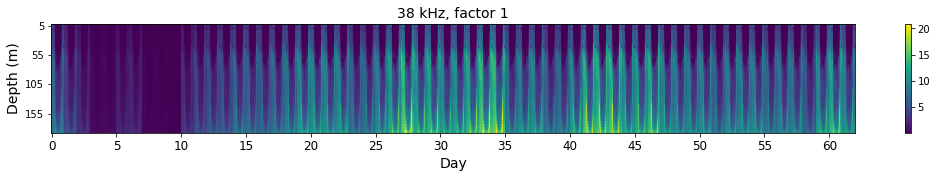

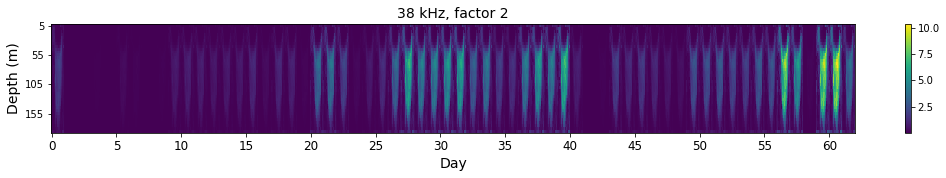

In [68]:
for fac in range(3):
    plt.figure(figsize=(18,2))
    plt.imshow(tl.unfold(tl.tensor(kr_nn_cube_all_fac[fac][0,:,:,:].squeeze()[:,::-1,:]),mode=1),aspect='auto')
    plt.xticks(np.arange(0,24*62,24*5),np.arange(0,62,5),fontsize=12)
    plt.xlabel('Day', fontsize=14)
    plt.yticks(np.arange(0,37,10),(np.arange(0,37,10)+1)*depth_bin_size)
    plt.ylabel('Depth (m)', fontsize=14)
    plt.colorbar()    
    plt.title('38 kHz, factor %d' % fac, fontsize=14)
plt.show()

### Frequency = 120 kHz

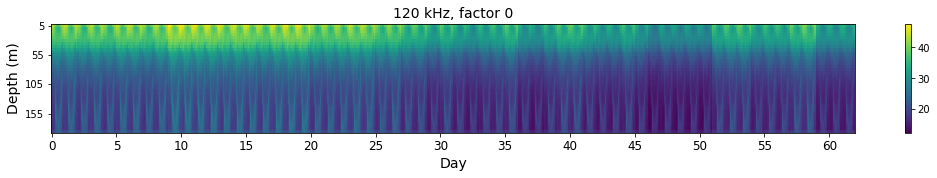

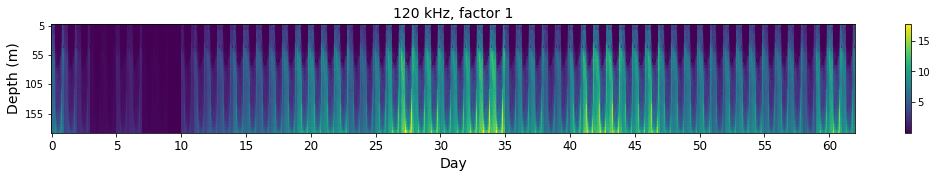

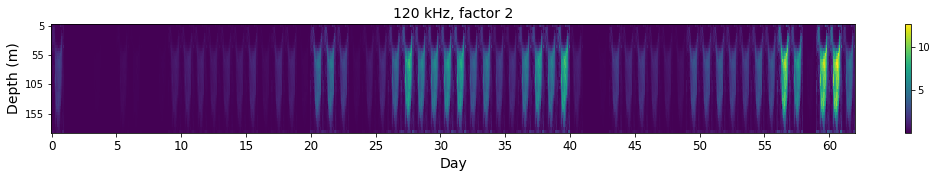

In [69]:
for fac in range(3):
    plt.figure(figsize=(18,2))
    plt.imshow(tl.unfold(tl.tensor(kr_nn_cube_all_fac[fac][1,:,:,:].squeeze()[:,::-1,:]),mode=1),aspect='auto')
    plt.xticks(np.arange(0,24*62,24*5),np.arange(0,62,5),fontsize=12)
    plt.xlabel('Day', fontsize=14)
    plt.yticks(np.arange(0,37,10),(np.arange(0,37,10)+1)*depth_bin_size)
    plt.ylabel('Depth (m)', fontsize=14)
    plt.colorbar()
    plt.title('120 kHz, factor %d' % fac, fontsize=14)
plt.show()

### Frequency = 200 kHz

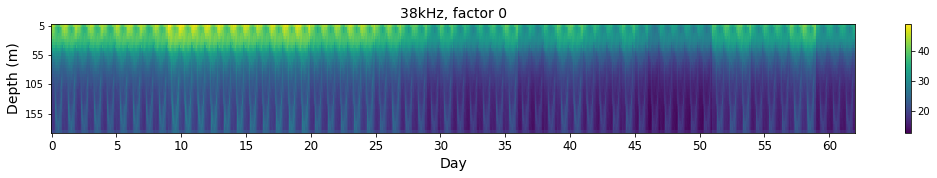

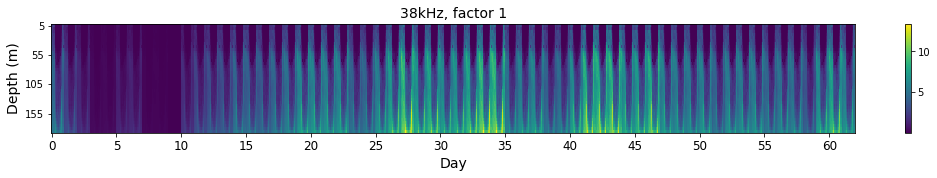

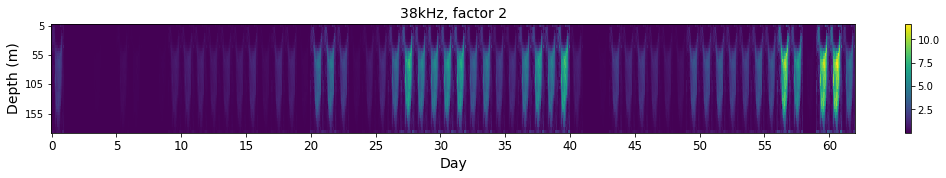

In [70]:
for fac in range(3):
    plt.figure(figsize=(18,2))
    plt.imshow(tl.unfold(tl.tensor(kr_nn_cube_all_fac[fac][2,:,:,:].squeeze()[:,::-1,:]),mode=1),aspect='auto')
    plt.xticks(np.arange(0,24*62,24*5),np.arange(0,62,5),fontsize=12)
    plt.xlabel('Day', fontsize=14)
    plt.yticks(np.arange(0,37,10),(np.arange(0,37,10)+1)*depth_bin_size)
    plt.ylabel('Depth (m)', fontsize=14)
    plt.colorbar()
    plt.title('38kHz, factor %d' % fac, fontsize=14)
plt.show()

### All factor reconstruction

In [71]:
recons_freq = []
for freq in range(3):
    recons_tmp = [tl.unfold(tl.tensor(kr_nn_cube_all_fac[fac][freq,:,:,:].squeeze()[:,::-1,:]),mode=1) 
                  for fac in range(3)]
    recons_freq.append(np.sum(np.array(recons_tmp),axis=0))

In [72]:
recons_freq = np.array(recons_freq)
recons_freq.shape

(3, 37, 1488)

Let's first check how the manual reconstruction looks like for each frequency:

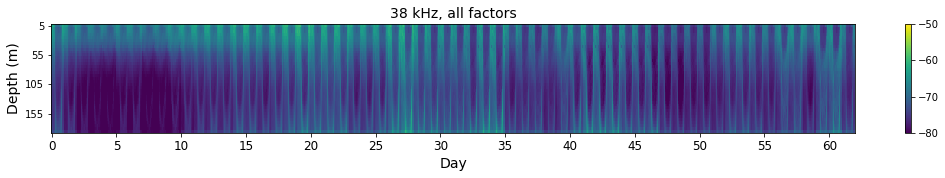

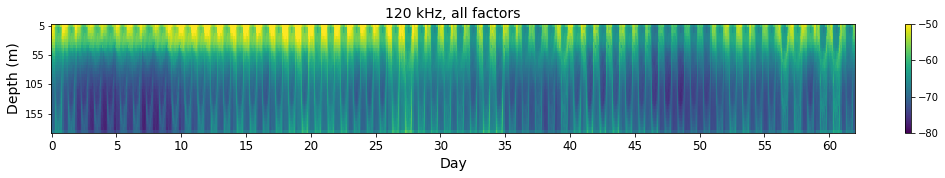

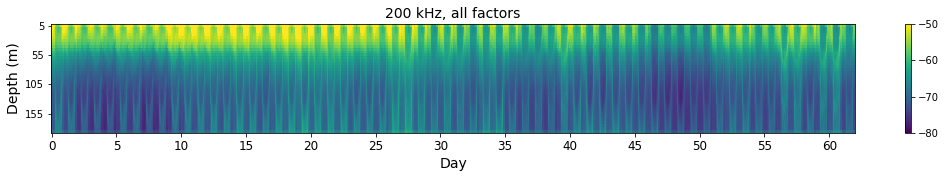

In [73]:
freq_name = [38,120,200]
for seq,freq in enumerate([38,120,200]):
    plt.figure(figsize=(18,2))
    plt.imshow(recons_freq[seq,:,:].squeeze()+sonar_tensor.min(),
               aspect='auto',vmin=-80, vmax=-50)
    plt.xticks(np.arange(0,24*62,24*5),np.arange(0,62,5),fontsize=12)
    plt.xlabel('Day', fontsize=14)
    plt.yticks(np.arange(0,37,10),(np.arange(0,37,10)+1)*depth_bin_size)
    plt.ylabel('Depth (m)', fontsize=14)
    plt.colorbar()
    plt.title('%d kHz, all factors' % freq, fontsize=14)
plt.show()

And now check how results of manual and tensorly naive reconstructions compare with the raw data:

In [74]:
L_sep_reduce.shape

(3, 62, 37, 24)

In [75]:
full_tensor_nonneg_3.shape

(3, 62, 888)

Frequency = 38 kHz

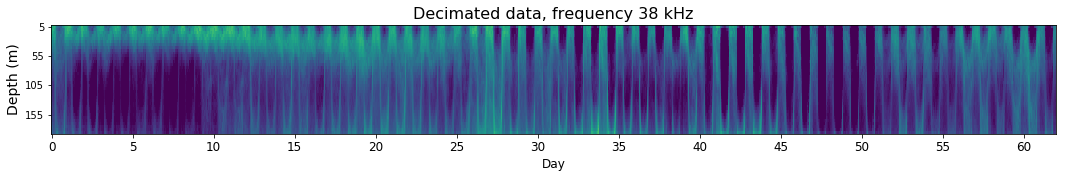

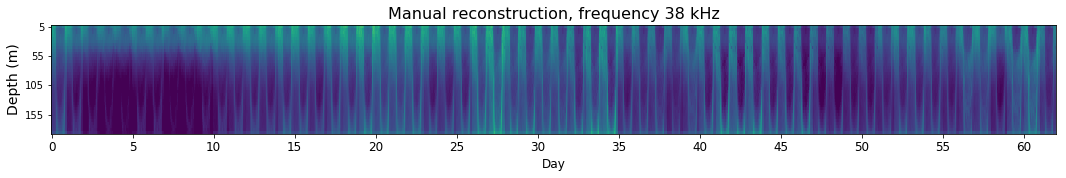

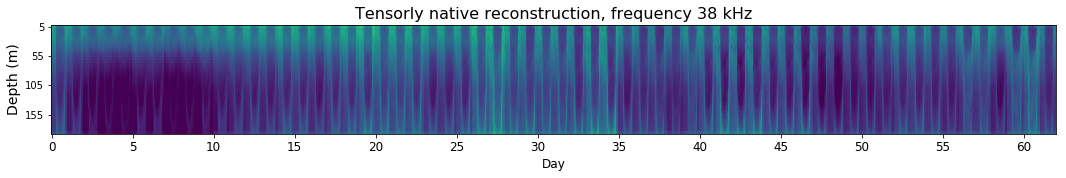

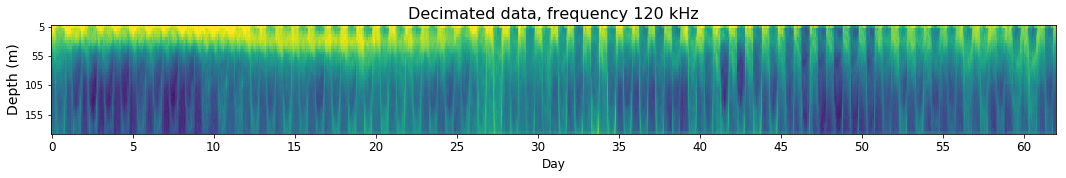

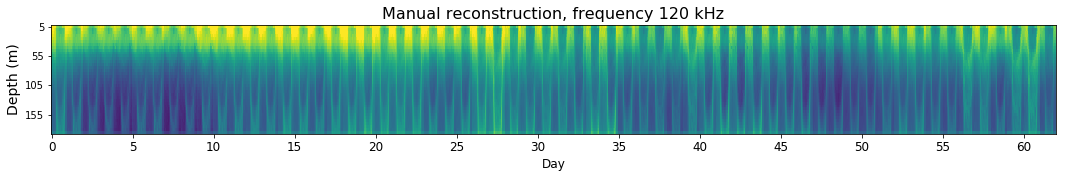

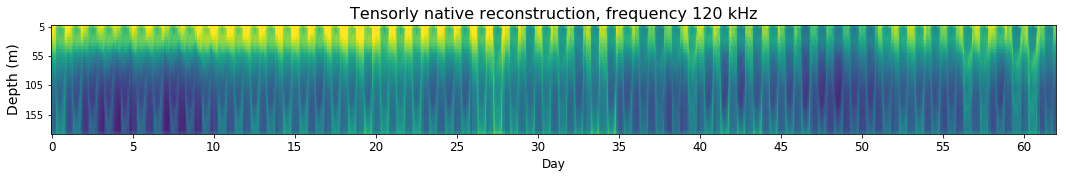

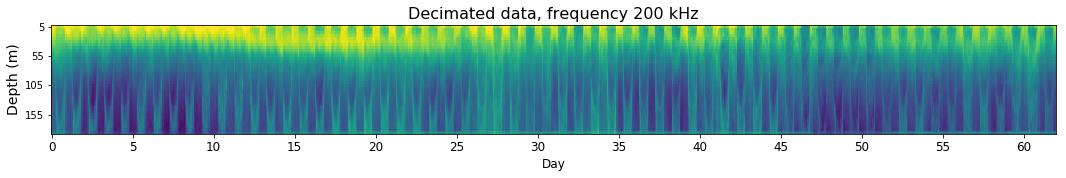

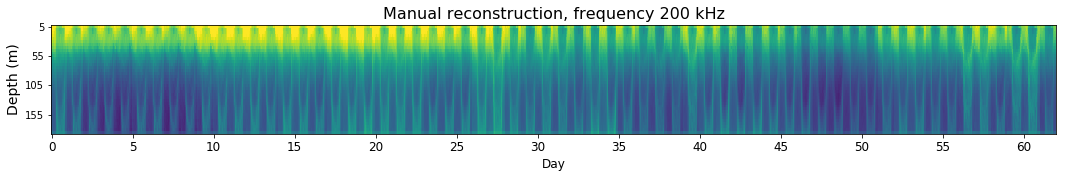

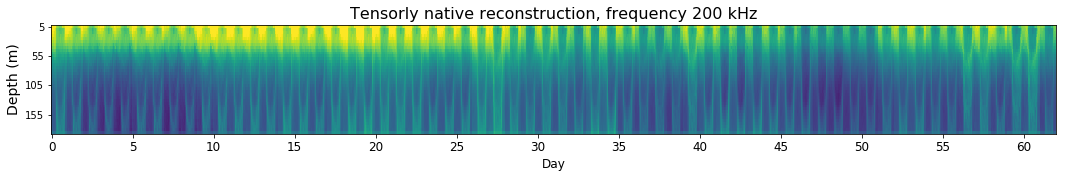

In [76]:
for freq_seq, freq in enumerate([38,120,200]):
    for panel in range(3):
        plt.figure(figsize=(18,2))
        if panel==0:
            plt.imshow(tl.unfold(tl.tensor(L_sep_reduce[freq_seq,:,:,:].squeeze()[:,::-1,:]),mode=1),
                       aspect='auto',vmin=-80, vmax=-50)
            plt.title('Decimated data, frequency %d kHz'%freq, fontsize=16)
        elif panel==1:
            plt.imshow(recons_freq[freq_seq,:,:].squeeze()+sonar_tensor.min(),
                       aspect='auto',vmin=-80, vmax=-50)
            plt.title('Manual reconstruction, frequency %d kHz'%freq, fontsize=16)
        else:
            plt.imshow(tl.unfold(tl.tensor(full_tensor_nonneg_3[freq_seq,:,:].squeeze().reshape(62,37,24)[:,::-1,:]+sonar_tensor.min()),mode=1),
                       aspect='auto',vmin=-80, vmax=-50)
            plt.title('Tensorly native reconstruction, frequency %d kHz'%freq, fontsize=16)        
        plt.xticks(np.arange(0,24*62,24*5),np.arange(0,62,5),fontsize=12)
        plt.xlabel('Day', fontsize=12)
        plt.yticks(np.arange(0,37,10),(np.arange(0,37,10)+1)*depth_bin_size)
        plt.ylabel('Depth (m)', fontsize=14)
        plt.show()

## Check frequency contribution from each component

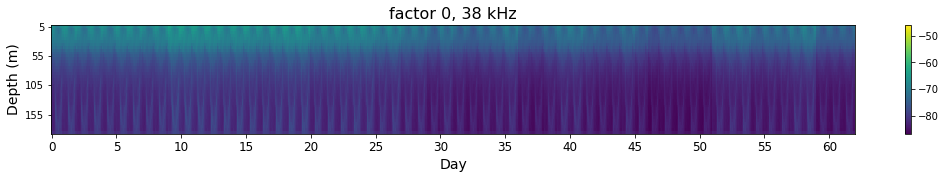

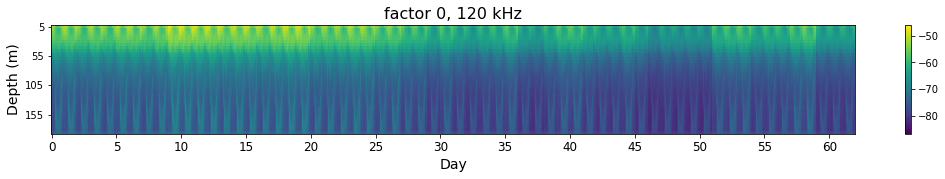

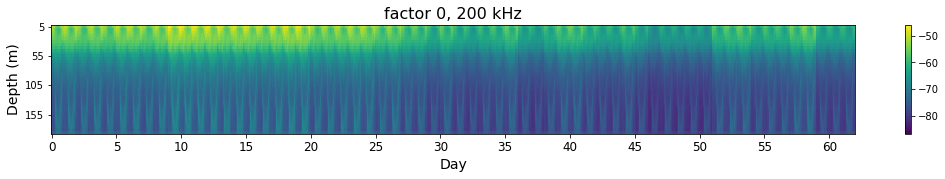

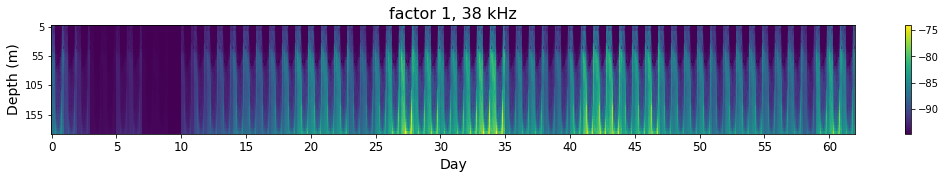

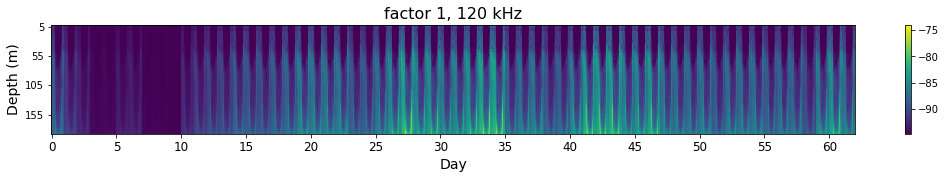

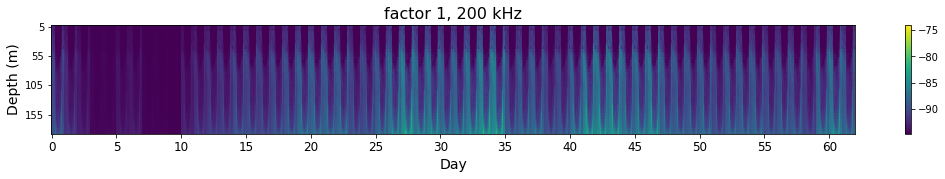

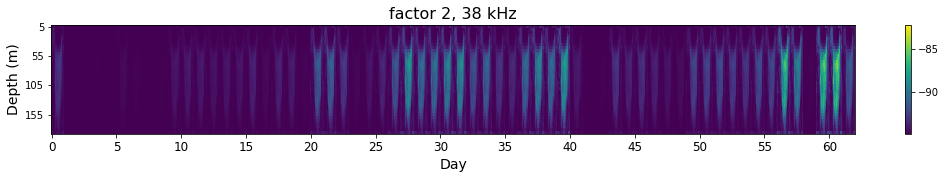

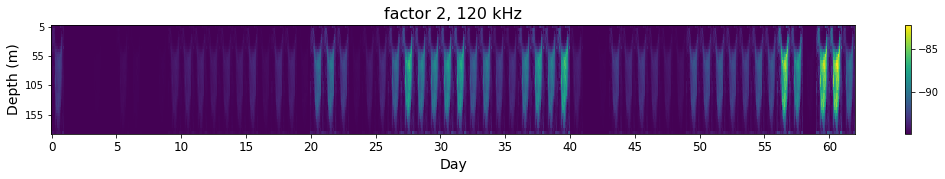

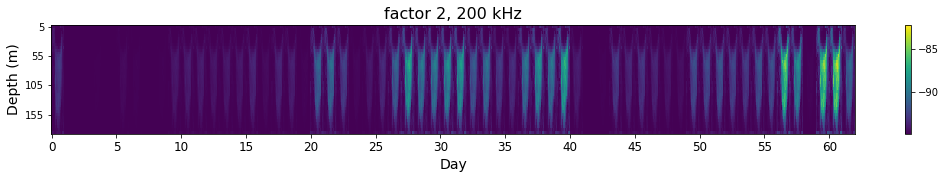

In [77]:
for fac in range(3):
    for freq_seq,freq in enumerate([38,120,200]):
        plt.figure(figsize=(18,2))
        vmax = kr_nn_cube_all_fac[fac].max()+sonar_tensor.min()
        vmin = kr_nn_cube_all_fac[fac].min()+sonar_tensor.min()
        plt.imshow(tl.unfold(tl.tensor(kr_nn_cube_all_fac[fac][freq_seq,:,:,:].squeeze()[:,::-1,:]),mode=1)+\
                   sonar_tensor.min(),
                   aspect='auto',vmin=vmin, vmax=vmax)
        plt.xticks(np.arange(0,24*62,24*5),np.arange(0,62,5),fontsize=12)
        plt.xlabel('Day', fontsize=14)
        plt.yticks(np.arange(0,37,10),(np.arange(0,37,10)+1)*depth_bin_size)
        plt.ylabel('Depth (m)', fontsize=14)
        plt.colorbar()    
        plt.title('factor %d, %d kHz' % (fac, freq), fontsize=16)
        plt.show()

## Try clustering over similarity between days

In [78]:
from scipy.cluster import hierarchy

In [79]:
from scipy.spatial.distance import pdist, squareform

In [80]:
factors_kruskal_nonneg_3[1].shape

(62, 3)

In [81]:
k = factors_kruskal_nonneg_3[1].T
k_norm = k.T-k.min(axis=1)
k_norm = k_norm/k_norm.max(axis=0)

In [82]:
Z = hierarchy.linkage(k_norm, 'ward')
Z_optimal = hierarchy.optimal_leaf_ordering(Z,k_norm)

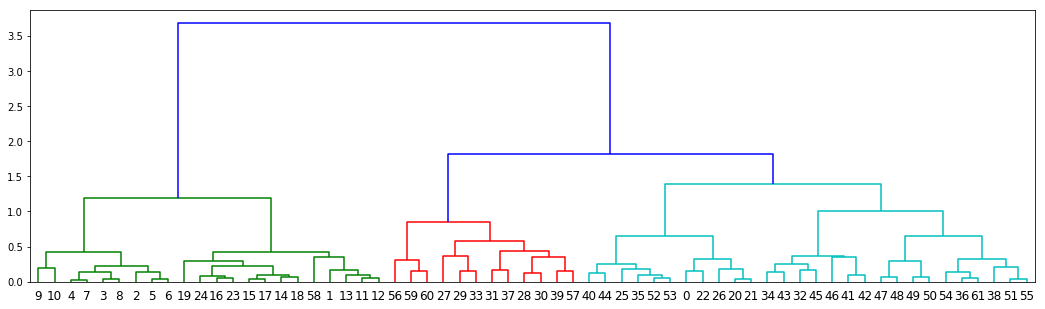

In [83]:
fig = plt.figure(figsize=(18, 5))
dn = hierarchy.dendrogram(Z,
                          leaf_rotation=0,
                          leaf_font_size=12,
                          color_threshold=1.5)
plt.show()

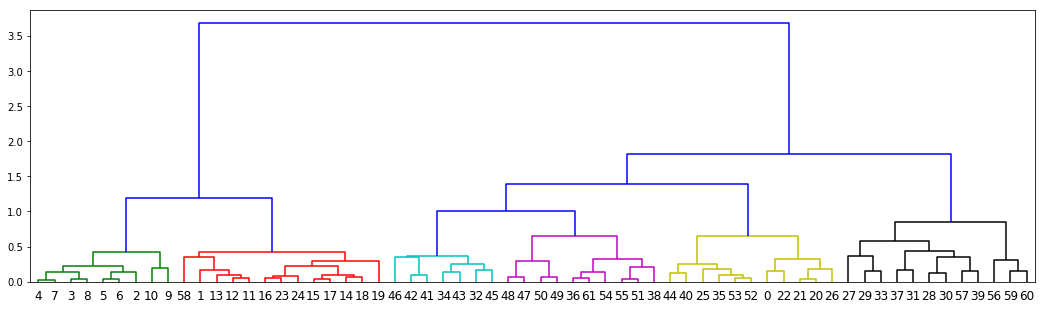

In [84]:
fig = plt.figure(figsize=(18, 5))
dn = hierarchy.dendrogram(Z_optimal,
                          leaf_rotation=0,
                          leaf_font_size=12,
                          color_threshold=1)
plt.show()

In [85]:
leaf_idx = hierarchy.leaves_list(Z_optimal)
leaf_idx

array([ 4,  7,  3,  8,  5,  6,  2, 10,  9, 58,  1, 13, 12, 11, 16, 23, 24,
       15, 17, 14, 18, 19, 46, 42, 41, 34, 43, 32, 45, 48, 47, 50, 49, 36,
       61, 54, 55, 51, 38, 44, 40, 25, 35, 53, 52,  0, 22, 21, 20, 26, 27,
       29, 33, 37, 31, 28, 30, 57, 39, 56, 59, 60], dtype=int32)

In [86]:
leaf_idx[50]

27

In [87]:
max_d = 1
clusters = hierarchy.fcluster(Z_optimal, max_d, criterion='distance')

cc = []
c_start = 0
c_end = 0
for c in np.arange(clusters.max())+1:
    c_idx = np.argwhere(clusters==c)
    print((c-1,c_start, c_start+len(c_idx)-1, np.array(c_idx).T))
    c_start = c_start+len(c_idx)
    cc.append(c_idx)

(0, 0, 8, array([[ 2,  3,  4,  5,  6,  7,  8,  9, 10]]))
(1, 9, 21, array([[ 1, 11, 12, 13, 14, 15, 16, 17, 18, 19, 23, 24, 58]]))
(2, 22, 28, array([[32, 34, 41, 42, 43, 45, 46]]))
(3, 29, 38, array([[36, 38, 47, 48, 49, 50, 51, 54, 55, 61]]))
(4, 39, 49, array([[ 0, 20, 21, 22, 25, 26, 35, 40, 44, 52, 53]]))
(5, 50, 61, array([[27, 28, 29, 30, 31, 33, 37, 39, 56, 57, 59, 60]]))


In [88]:
leaf_idx_new = [cc[0],cc[1],cc[4],cc[3][::-1],cc[2],cc[5]]
leaf_idx_new = np.vstack(leaf_idx_new).squeeze()

In [89]:
leaf_idx_new[40]

47

In [90]:
D = pdist(k_norm, 'euclidean')
Dc = pdist(k_norm[leaf_idx], 'euclidean')
Dc_new = pdist(k_norm[leaf_idx_new], 'euclidean')

In [91]:
D_square = squareform(D)
Dc_square = squareform(Dc)
Dc_new_square = squareform(Dc_new)

In [92]:
(D_square.max(), D_square.min())

(1.4839839075201384, 0.0)

Below plot the similarity matrix (1-normalized distance):

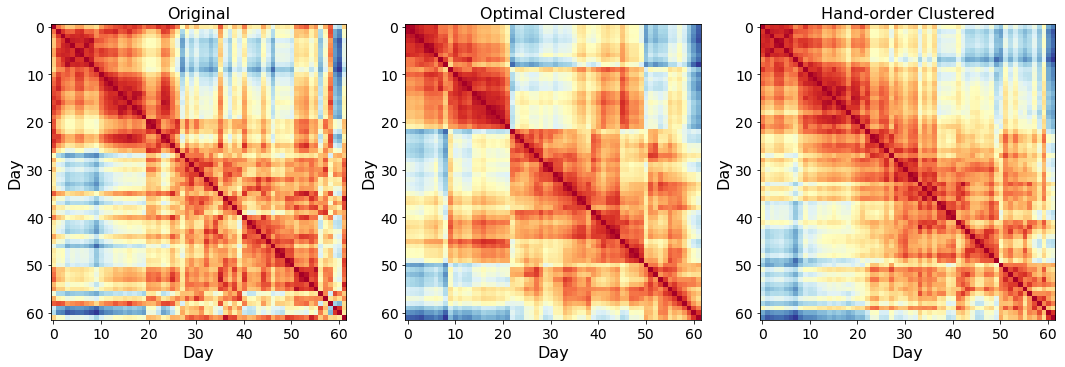

In [93]:
fig,ax = plt.subplots(1,3,figsize=(18,6))
for panel in range(3):
    if panel==0:
        ax[panel].imshow(1-D_square/D_square.max(),cmap='RdYlBu_r')
        ax[panel].set_title('Original',fontsize=16)
    elif panel==1:
        ax[panel].imshow(1-Dc_square/Dc_square.max(),cmap='RdYlBu_r')
        ax[panel].set_title('Optimal Clustered',fontsize=16)        
    else:
        ax[panel].imshow(1-Dc_new_square/Dc_new_square.max(),cmap='RdYlBu_r')
        ax[panel].set_title('Hand-order Clustered',fontsize=16)        
    ax[panel].set_xlabel('Day',fontsize=16)
    ax[panel].set_ylabel('Day',fontsize=16)
    plt.setp(ax[panel].get_xticklabels(),fontsize=14)
    plt.setp(ax[panel].get_yticklabels(),fontsize=14)
plt.show()

And the connection between the original day sequence and the clustered output:

In [94]:
idx_link = np.vstack((leaf_idx_new,np.arange(62)))
idx_link

array([[ 2,  3,  4,  5,  6,  7,  8,  9, 10,  1, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 23, 24, 58,  0, 20, 21, 22, 25, 26, 35, 40, 44, 52,
        53, 61, 55, 54, 51, 50, 49, 48, 47, 38, 36, 32, 34, 41, 42, 43,
        45, 46, 27, 28, 29, 30, 31, 33, 37, 39, 56, 57, 59, 60],
       [ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15,
        16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31,
        32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47,
        48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61]])

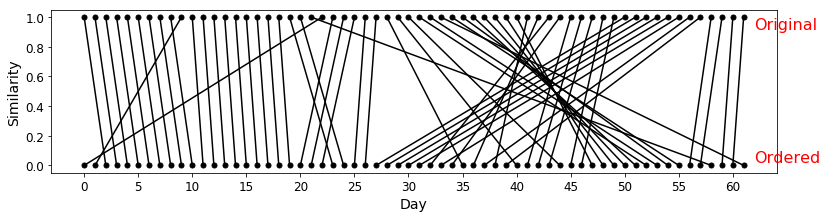

In [95]:
plt.figure(figsize=(13,3))
plt.plot(idx_link,[0,1],'k.-',markersize=10)
plt.xticks(np.arange(0,62,5),fontsize=12)
plt.xlabel('Day',fontsize=14)
plt.yticks(np.arange(0,1.1,0.2),fontsize=12)
plt.ylabel('Similarity',fontsize=14)
plt.text(62,0,'Ordered',{'fontsize':16,'va':'bottom','color':'r'})
plt.text(62,1,'Original',{'fontsize':16,'va':'top','color':'r'})
plt.show()

In [96]:
import dill
dill.dump_session('dill_2018-11-02_parafac_dailyimage.db')

In [97]:
# To load pickled jupyter environment and data
# dill.load_session('notebook_env.db')